In [ ]:
#RT-DETR-Large
from google.colab import drive
import os

#mounting google drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

#installing latesr version of required libraries
print("Installing ultralytics and albumentations...")
!pip install -q "ultralytics>=8.1.0" "albumentations>=1.3.0"

#setting env variable
os.environ["WANDB_MODE"] = "disabled"

print("✅ Setup complete. WANDB logging is disabled.")

Mounting Google Drive...
Mounted at /content/drive
Installing ultralytics and albumentations...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.4 MB/s eta 0:00:00
✅ Setup complete. WANDB logging is disabled.


In [ ]:
#unzipping db
import os
import zipfile
import glob

ZIP_PATH = "/content/drive/MyDrive/Trucks_YOLO.zip"
EXTRACT_DIR = "/content/Trucks_YOLO_unzipped"

os.makedirs(EXTRACT_DIR, exist_ok=True)

print(f"Unzipping {ZIP_PATH}...")
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)
    print("Unzip complete.")

#auto-detect the folder containing 'images' and 'labels'
possible_dirs = []
for root, dirs, files in os.walk(EXTRACT_DIR):
    if 'images' in dirs and 'labels' in dirs:
            possible_dirs.append(root)

if len(possible_dirs) == 0:
    raise FileNotFoundError("ERROR: Couldn't find folders named 'images' and 'labels' inside the zip.")

#original db path
ORIGINAL_DATA_DIR = possible_dirs[0]

print(f"✅ Dataset found at: {ORIGINAL_DATA_DIR}")

#define paths to original images and labels
ORIG_IMG_DIR = os.path.join(ORIGINAL_DATA_DIR, "images")
ORIG_LBL_DIR = os.path.join(ORIGINAL_DATA_DIR, "labels")

print(f"Image folder: {ORIG_IMG_DIR}")
print(f"Label folder: {ORIG_LBL_DIR}")

Unzipping /content/drive/MyDrive/Trucks_YOLO.zip...
Unzip complete.
✅ Dataset found at: /content/Trucks_YOLO_unzipped/Trucks_YOLO/train
Image folder: /content/Trucks_YOLO_unzipped/Trucks_YOLO/train/images
Label folder: /content/Trucks_YOLO_unzipped/Trucks_YOLO/train/labels


In [ ]:
#create train/val split
import glob
import random
import shutil

#formatted db new root
DS_ROOT = "/content/Trucks_YOLO_dataset"

#defining train/val path
train_img_dir = os.path.join(DS_ROOT, "train", "images")
train_lbl_dir = os.path.join(DS_ROOT, "train", "labels")
val_img_dir = os.path.join(DS_ROOT, "val", "images")
val_lbl_dir = os.path.join(DS_ROOT, "val", "labels")

if os.path.exists(DS_ROOT):
    shutil.rmtree(DS_ROOT)

for d in [train_img_dir, train_lbl_dir, val_img_dir, val_lbl_dir]:
    os.makedirs(d, exist_ok=True)

print(f"Scanning for images in {ORIG_IMG_DIR}...")
all_images = (glob.glob(os.path.join(ORIG_IMG_DIR, "*.jpg")) +
              glob.glob(os.path.join(ORIG_IMG_DIR, "*.jpeg")) +
              glob.glob(os.path.join(ORIG_IMG_DIR, "*.png")))

random.seed(42)
random.shuffle(all_images)

#split the data (90% train, 10% val)
split_idx = int(len(all_images) * 0.9)
train_imgs = all_images[:split_idx]
val_imgs = all_images[split_idx:]

print(f"Total images found: {len(all_images)}")
print(f"Splitting into {len(train_imgs)} training images and {len(val_imgs)} validation images.")

#Function to copy image/label pairs
def copy_pairs(img_list, dest_img_dir, dest_lbl_dir):
    copied_count = 0
    for img_path in img_list:
        base_name = os.path.basename(img_path)
        name, ext = os.path.splitext(base_name)
        lbl_name = name + ".txt"
        lbl_path = os.path.join(ORIG_LBL_DIR, lbl_name)

        shutil.copy(img_path, os.path.join(dest_img_dir, base_name))

        #copy label if it exists, otherwise create an empty file
        if os.path.exists(lbl_path):
            shutil.copy(lbl_path, os.path.join(dest_lbl_dir, lbl_name))
        else:
            #create empty label file for background images
            open(os.path.join(dest_lbl_dir, lbl_name), 'w').close()
        copied_count += 1
    return copied_count

print("Copying training files...")
copy_pairs(train_imgs, train_img_dir, train_lbl_dir)
print("Copying validation files...")
copy_pairs(val_imgs, val_img_dir, val_lbl_dir)

print("✅ Train/Val split created successfully.")

Scanning for images in /content/Trucks_YOLO_unzipped/Trucks_YOLO/train/images...
Total images found: 1006
Splitting into 905 training images and 101 validation images.
Copying training files...
Copying validation files...
✅ Train/Val split created successfully.


In [ ]:
#create data.yaml ---
import yaml
import os
import glob

#finding all unique class IDs from label files
print(f"Scanning labels in {ORIG_LBL_DIR} to find class names...")
class_ids = set()
for lbl_file in glob.glob(os.path.join(ORIG_LBL_DIR, "*.txt")):
    with open(lbl_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if parts:
                try:
                    class_ids.add(int(parts[0]))
                except ValueError:
                    print(f"Warning: Skipping invalid line in {lbl_file}: {line}")

if not class_ids:
    print("Warning: No class IDs found. Assuming 1 class 'axle' (ID 0).")
    num_classes = 1
    #if more then one class then edit here
    class_names = ['axle']
else:
    num_classes = max(class_ids) + 1
    class_names = [f"class_{i}" for i in range(num_classes)]
    if num_classes == 1:
        class_names = ["axle"] # Assuming 'axle' is class 0

print(f"Found {num_classes} classes. IDs: {sorted(list(class_ids))}")
print(f"Using class names: {class_names}")

#create data.yaml dictionary
data_yaml = {
    'path': DS_ROOT,
    'train': 'train/images',
    'val': 'val/images',
    'names': class_names
}

DATA_YAML_PATH = os.path.join(DS_ROOT, "data.yaml")
with open(DATA_YAML_PATH, "w") as f:
    yaml.safe_dump(data_yaml, f, sort_keys=False)

print(f"✅ Created {DATA_YAML_PATH}:")
!cat {DATA_YAML_PATH}

Scanning labels in /content/Trucks_YOLO_unzipped/Trucks_YOLO/train/labels to find class names...
Found 1 classes. IDs: [0]
Using class names: ['axle']
✅ Created /content/Trucks_YOLO_dataset/data.yaml:
path: /content/Trucks_YOLO_dataset
train: train/images
val: val/images
names:
- axle


Visualizing random validation sample: /content/Trucks_YOLO_dataset/val/images/20170418074502_color-[ROI-1]-109.jpg


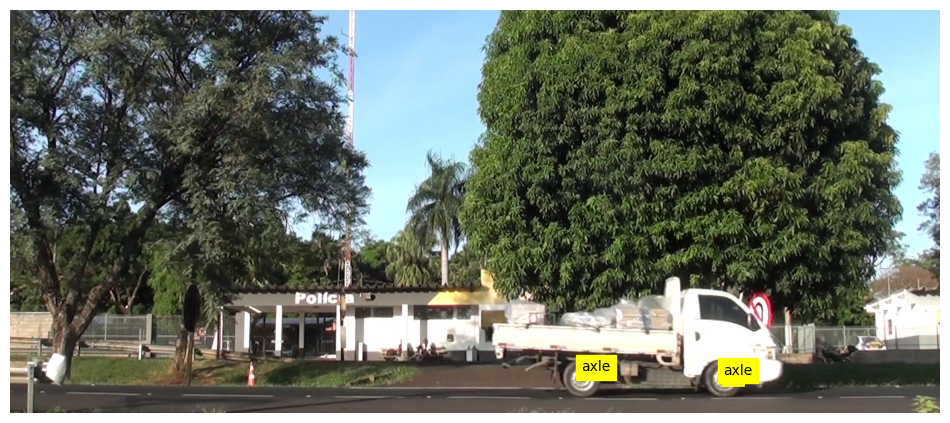

In [ ]:
#sanity chceck
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

val_img_dir = os.path.join(DS_ROOT, "val", "images")
val_lbl_dir = os.path.join(DS_ROOT, "val", "labels")
class_names = data_yaml['names'] # from Cell 4

#picking random image for validation
sample_name = random.choice(os.listdir(val_img_dir))
img_path = os.path.join(val_img_dir, sample_name)
lbl_path = os.path.join(val_lbl_dir, os.path.splitext(sample_name)[0] + ".txt")

print(f"Visualizing random validation sample: {img_path}")

#load image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape

#plot image
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

#load and plot bounding boxes
if os.path.exists(lbl_path):
    with open(lbl_path) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue

            cid = int(parts[0])
            cx, cy, bw, bh = map(float, parts[1:])

            #convert YOLO to pixel coordinates
            xmin = (cx - bw/2) * w
            ymin = (cy - bh/2) * h
            box_w = bw * w
            box_h = bh * h

            label = class_names[cid]

            #create a rectangle patch
            rect = patches.Rectangle(
                (xmin, ymin), box_w, box_h,
                linewidth=2, edgecolor='yellow', facecolor='none'
            )
            ax.add_patch(rect)

            #add label text
            ax.text(
                xmin, ymin - 10, label,
                color='black', backgroundcolor='yellow', fontsize=10
            )

ax.axis('off')
plt.show()

In [ ]:
#"Monkey-Patch" for weather augmentations to make db wide and model robust
import albumentations as A
from ultralytics.data.augment import Albumentations
from ultralytics.utils import LOGGER, colorstr

print("Applying custom weather augmentation patch...")

#store the original initfunction
_original_init = Albumentations.__init__

#define our new init function
def __init__(self, p=1.0):
    """
    Replaces the default Albumentations __init__ to add our new transforms.
    """
    #ccall the original init to get the default transforms (this loads the default Blur, MedianBlur, ToGray, CLAHE)
    _original_init(self, p=p)

    #defining custom weather transforms
    weather_transforms = [
        A.RandomRain(p=0.2, brightness_coefficient=0.9, drop_width=1, blur_value=3),
        A.RandomFog(p=0.2, fog_coef_lower=0.3, fog_coef_upper=0.7, alpha_coef=0.1),
        A.RandomSnow(p=0.2, brightness_coeff=2.0, snow_point_lower=0.1, snow_point_upper=0.3),
        A.RandomSunFlare(p=0.1, flare_roi=(0, 0, 1, 0.5), angle_lower=0.5),
        A.RandomShadow(p=0.2, num_shadows_lower=1, num_shadows_upper=3, shadow_dimension=5),
    ]

    #we use A.OneOf to apply ONLY ONE weather effect at a time (50% chance)
    self.transform.transforms.insert(0, A.OneOf(weather_transforms, p=0.5))
    self.transform.transforms.insert(1, A.MotionBlur(p=0.2, blur_limit=(3, 7)))
    self.transform.transforms.insert(2, A.GaussNoise(p=0.2, var_limit=(10.0, 50.0)))

    prefix = colorstr('albumentations: ')
    LOGGER.info(prefix + ", ".join(f'{x}'.replace('always_apply=False, ', '') for x in self.transform.transforms if x.p))
    print("✅ Custom weather augmentations (Rain, Fog, Snow, etc.) are now ACTIVE.")

#replace our old init with new init, now on,only new init will be referred
Albumentations.__init__ = __init__

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Applying custom weather augmentation patch...


In [ ]:
# training
from ultralytics import RTDETR
import os

#load the pre-trained RT-DETR-Large model
model = RTDETR('rtdetr-l.pt')

#define training parameters
DATA_YAML = os.path.join(DS_ROOT, "data.yaml")
EPOCHS = 60
BATCH_SIZE = 4
PATIENCE = 10
IMG_SIZE = 640

PROJECT_NAME = "/content/drive/MyDrive/RTDETR_Axle_Runs"
RUN_NAME = "rtdetr_l_robust_weather_v1"

print(f"Starting training...")
print(f"Model: RT-DETR-Large")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Results will be saved to: {PROJECT_NAME}/{RUN_NAME}")
print("---")
print("Augmentations active: ALL standard geos (mosaic, translate, etc.)")
print("PLUS all custom weather effects (Rain, Fog, Snow, Blur, Noise).")
print("---")

results = model.train(
    data=DATA_YAML,
    epochs=EPOCHS,
    patience=PATIENCE,
    batch=BATCH_SIZE,
    imgsz=IMG_SIZE,

    project=PROJECT_NAME,
    name=RUN_NAME,
    exist_ok=True, #allows overwriting this run
    save_period=-1, #only save final and best checkpoint

    #geometric transformations (crop, translate, rotate, scale)
    translate=0.2,    # (default: 0.1)
    scale=0.9,        # (default: 0.9)
    degrees=15.0,     # (default: 0.0)
    shear=5.0,        # (default: 0.0)
    perspective=0.001,  # (default: 0.0)
    flipud=0.0,     # (default: 0.0) - don't flip trucks upside down
    fliplr=0.5,     # (default: 0.5) - 50% chance of horizontal flip

    #simulates partial/occluded views
    mosaic=1.0,     # (default: 1.0)
    mixup=0.1,      # (default: 0.0)
    copy_paste=0.1, # (default: 0.0)

    # Color
    hsv_h=0.025,  # (default: 0.015)more hue variation
    hsv_s=0.9,    # (default: 0.7)more saturation variation

    optimizer='auto', #let ultralytics pick the best optimizer
    cos_lr=True,      #use cosine learning rate scheduler
    amp=True,
    verbose=True
)

print("✅ Training finished.")

Starting training...
Model: RT-DETR-Large
Epochs: 60
Batch Size: 4
Results will be saved to: /content/drive/MyDrive/RTDETR_Axle_Runs/rtdetr_l_robust_weather_v1
---
Augmentations active: ALL standard geos (mosaic, translate, etc.)
PLUS all custom weather effects (Rain, Fog, Snow, Blur, Noise).
---
Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/Trucks_YOLO_dataset/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.025, hsv_s=0.9, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False,

/tmp/ipython-input-1874058527.py:23: UserWarning: Argument(s) 'fog_coef_lower, fog_coef_upper' are not valid for transform RandomFog
  A.RandomFog(p=0.2, fog_coef_lower=0.3, fog_coef_upper=0.7, alpha_coef=0.1),
/tmp/ipython-input-1874058527.py:24: UserWarning: Argument(s) 'snow_point_lower, snow_point_upper' are not valid for transform RandomSnow
  A.RandomSnow(p=0.2, brightness_coeff=2.0, snow_point_lower=0.1, snow_point_upper=0.3),
/tmp/ipython-input-1874058527.py:25: UserWarning: Argument(s) 'angle_lower' are not valid for transform RandomSunFlare
  A.RandomSunFlare(p=0.1, flare_roi=(0, 0, 1, 0.5), angle_lower=0.5),
/tmp/ipython-input-1874058527.py:26: UserWarning: Argument(s) 'num_shadows_lower, num_shadows_upper' are not valid for transform RandomShadow
  A.RandomShadow(p=0.2, num_shadows_lower=1, num_shadows_upper=3, shadow_dimension=5),
/tmp/ipython-input-1874058527.py:36: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  self.transform.transforms.ins

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1569.2±1478.1 MB/s, size: 550.7 KB)
val: Scanning /content/Trucks_YOLO_dataset/val/labels... 101 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 101/101 1.4Kit/s 0.1s
val: New cache created: /content/Trucks_YOLO_dataset/val/labels.cache
Plotting labels to /content/drive/MyDrive/RTDETR_Axle_Runs/rtdetr_l_robust_weather_v1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 143 weight(decay=0.0), 206 weight(decay=0.0005), 226 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/RTDETR_Axle_Runs/rtdetr_l_robust_weather_v1
Starting training for 60 epochs...

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       1/60       3.4G      1.745      1.639     0.6558         49   

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       1/60      3.65G      1.197     0.7477     0.4276          1        640: 100% ━━━━━━━━━━━━ 227/227 1.7it/s 2:13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 1.9it/s 6.7s
                   all        101        392      0.759      0.746      0.709      0.233

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       2/60      3.88G     0.8721     0.5353     0.2125         34        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       2/60      3.94G      1.018      0.458     0.2922         18        640: 100% ━━━━━━━━━━━━ 227/227 1.7it/s 2:12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.4it/s 2.0s
                   all        101        392      0.811      0.245       0.25      0.137

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       3/60      4.02G      1.086     0.4434     0.1981         17        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       3/60      4.03G     0.9671     0.5207     0.2624          4        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.1it/s 2.1s
                   all        101        392      0.875      0.745      0.826      0.433

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       4/60      4.11G     0.8973     0.4596     0.1008         43        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       4/60      4.12G     0.9618     0.5179     0.2539          3        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.2it/s 2.1s
                   all        101        392      0.939      0.722      0.822      0.406

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       5/60      4.32G     0.8132     0.5052     0.1574         17        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       5/60      4.33G     0.9666     0.4955     0.2523         22        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 2:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.4it/s 2.0s
                   all        101        392       0.49      0.107     0.0945     0.0573

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       6/60      4.46G     0.3782      0.596     0.2037          9        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       6/60      4.49G     0.9928     0.4787     0.2537         12        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 2:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.2it/s 2.1s
                   all        101        392      0.881      0.755      0.847      0.465

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       7/60      4.68G      1.545     0.4293      0.544         23        640: 0% ──────────── 0/227  0.7s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       7/60       4.7G     0.8605     0.5406     0.2149         15        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.3it/s 2.1s
                   all        101        392      0.871      0.776      0.843      0.414

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       8/60      4.88G      1.027     0.5758     0.3548         18        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       8/60      4.88G     0.8876     0.5189     0.2103         16        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.2it/s 2.1s
                   all        101        392      0.958      0.735      0.846      0.391

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       9/60      5.02G      1.005     0.4557     0.3277         31        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       9/60      5.08G      0.876     0.5049     0.2177         10        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 2:02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.1it/s 2.1s
                   all        101        392      0.928      0.773      0.865      0.434

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      10/60      5.28G      1.025     0.4816     0.3819         22        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      10/60      5.29G     0.8619     0.4985     0.1922          5        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.1it/s 2.1s
                   all        101        392      0.927      0.768      0.831      0.425

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      11/60      5.39G     0.6934     0.4312     0.1487         30        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      11/60      5.47G     0.8131      0.528     0.1896          4        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.1it/s 2.1s
                   all        101        392      0.958      0.587      0.677      0.383

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      12/60       5.6G     0.6375     0.5395    0.08896         25        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      12/60      5.65G     0.8365     0.5017      0.185          1        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 2:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.3it/s 2.1s
                   all        101        392      0.956      0.696      0.806      0.427

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      13/60      5.85G     0.9763      0.445     0.1837         34        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      13/60      5.86G     0.7962     0.5201     0.1724         17        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 2:01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 5.4it/s 2.4s
                   all        101        392      0.924      0.619      0.706      0.328

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      14/60      5.89G     0.8297     0.5427     0.1599         18        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      14/60      6.07G      0.788     0.5157     0.1726          9        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 5.0it/s 2.6s
                   all        101        392      0.938       0.76      0.851      0.391

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      15/60      6.18G     0.9682     0.4823     0.1548         52        640: 0% ──────────── 0/227  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      15/60      6.21G     0.7898     0.5213      0.177          6        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.0it/s 3.2s
                   all        101        392      0.923      0.536      0.625      0.366

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      16/60      6.33G     0.9687     0.5775     0.1709         39        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      16/60      6.42G     0.7629     0.5154     0.1677          3        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 1:59
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.1it/s 3.2s
                   all        101        392      0.947      0.774      0.871      0.531

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      17/60      6.59G      0.453     0.4785    0.09717         28        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      17/60       6.6G     0.8024     0.5084     0.1857          3        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.3it/s 2.1s
                   all        101        392      0.886      0.474      0.527      0.327

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      18/60      6.73G     0.6167     0.5104     0.1201         32        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      18/60      6.78G     0.7871      0.527      0.166          6        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.1it/s 2.1s
                   all        101        392      0.919      0.753      0.822      0.416

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      19/60      6.91G     0.7581     0.4581    0.07974         24        640: 0% ──────────── 0/227  0.8s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      19/60      6.97G     0.8193     0.5153     0.1795         12        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.2it/s 3.1s
                   all        101        392       0.95      0.776      0.866      0.597

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      20/60      7.12G     0.7693     0.4399     0.1057         25        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      20/60      7.18G     0.7719     0.5001     0.1647         10        640: 100% ━━━━━━━━━━━━ 227/227 1.7it/s 2:10
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.2it/s 2.1s
                   all        101        392      0.945      0.788       0.85      0.512

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      21/60      7.38G     0.6226     0.6122     0.1584         22        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      21/60      7.39G     0.7595      0.494     0.1591          3        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 2:02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.5it/s 2.9s
                   all        101        392      0.916       0.78      0.839       0.49

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      22/60       4.4G     0.9255     0.4416     0.1057         27        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      22/60       4.4G     0.7434      0.509     0.1552         13        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 1:59
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 5.1it/s 2.5s
                   all        101        392      0.936      0.804       0.87      0.537

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      23/60       4.4G      1.106      0.448     0.2077         22        640: 0% ──────────── 0/227  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      23/60       4.4G     0.7691     0.4991     0.1666          8        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 1:57
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 5.8it/s 2.2s
                   all        101        392      0.954      0.785      0.876      0.519

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      24/60       4.4G     0.7046     0.3978     0.1214         25        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      24/60      4.45G     0.6901     0.5155     0.1446          1        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 2:02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.2it/s 2.1s
                   all        101        392      0.932      0.791      0.881      0.587

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      25/60      4.55G     0.3483     0.4609    0.08867         23        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      25/60      4.55G     0.7221     0.5045     0.1485          7        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 5.5it/s 2.4s
                   all        101        392      0.947      0.763      0.864      0.542

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      26/60      4.65G     0.7507     0.4243    0.07221         41        640: 0% ──────────── 0/227  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      26/60      4.65G     0.7636     0.4958     0.1552         10        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.5it/s 2.9s
                   all        101        392      0.929       0.76      0.866      0.589

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      27/60      4.77G     0.5596     0.5182     0.2934         12        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      27/60      4.77G     0.7313     0.5109     0.1649          2        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.1it/s 2.1s
                   all        101        392      0.936      0.783      0.875      0.544

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      28/60      4.85G     0.4488     0.5234     0.0598         23        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      28/60      4.88G     0.7349     0.4987     0.1531          4        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.2it/s 2.1s
                   all        101        392      0.921      0.799      0.859      0.563

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      29/60      5.08G     0.5868     0.3755     0.1191         22        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      29/60      5.09G     0.7355     0.4875     0.1534         11        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.5it/s 2.9s
                   all        101        392      0.944      0.758      0.849      0.537

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      30/60      5.12G      1.261     0.4974     0.2631         21        640: 0% ──────────── 0/227  0.7s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      30/60      5.28G     0.7495     0.5082     0.1652          1        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.1it/s 2.1s
                   all        101        392      0.934       0.79       0.87      0.573

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      31/60      5.43G     0.4895     0.5459      0.134         24        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      31/60      5.46G     0.7173     0.4983     0.1513          0        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 2:02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 5.9it/s 2.2s
                   all        101        392      0.953       0.78      0.884      0.585

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      32/60      5.64G     0.8113     0.4616     0.1259         27        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      32/60      5.65G      0.701     0.4888     0.1435          4        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 1:59
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.2it/s 2.1s
                   all        101        392      0.939      0.786      0.887        0.6

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      33/60      5.77G     0.9662      0.413     0.1659         37        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      33/60      5.83G     0.7145     0.5054     0.1396         13        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:10
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.7it/s 2.8s
                   all        101        392      0.926      0.797      0.888      0.552

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      34/60      6.03G     0.5681     0.5166      0.112         16        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      34/60      6.04G     0.6878     0.5002     0.1397         14        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.0it/s 2.2s
                   all        101        392      0.922      0.788      0.877       0.59

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      35/60      6.17G     0.4136     0.4005     0.1955         26        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      35/60      6.23G     0.6929     0.4932     0.1433         13        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.0it/s 2.2s
                   all        101        392      0.928      0.781       0.86      0.523

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      36/60       6.4G     0.5457     0.5458     0.1191         28        640: 0% ──────────── 0/227  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      36/60      6.41G     0.6913     0.5021      0.132         11        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 2:02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.4it/s 3.8s
                   all        101        392      0.915      0.798      0.859      0.557

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      37/60      6.61G      1.013     0.4501     0.1607         28        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      37/60      6.62G     0.6437     0.4952     0.1233          3        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.2it/s 2.1s
                   all        101        392      0.934      0.801      0.869       0.57

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      38/60      6.73G     0.7884     0.4646     0.1371         38        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      38/60      6.79G     0.6762     0.4768     0.1338          9        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 2:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.2it/s 2.1s
                   all        101        392      0.942       0.77      0.845      0.556

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      39/60      6.99G     0.7441     0.5173     0.2737         19        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      39/60         7G     0.6415     0.4834     0.1286          5        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 2:01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.2it/s 2.1s
                   all        101        392      0.937      0.792      0.854      0.551

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      40/60       7.1G     0.7972     0.5978    0.08775         20        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      40/60      7.17G     0.6827      0.481     0.1269         11        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 5.8it/s 2.3s
                   all        101        392      0.949      0.762      0.842      0.553

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      41/60      7.38G     0.8794     0.5374     0.1015         12        640: 0% ──────────── 0/227  0.9s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      41/60      7.39G     0.6543      0.484     0.1306         21        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 1:58
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.1it/s 2.1s
                   all        101        392      0.939      0.798       0.89      0.608

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      42/60      4.44G     0.9125     0.6497     0.2724         31        640: 0% ──────────── 0/227  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      42/60      4.44G     0.6449     0.4776     0.1226          5        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.4it/s 2.9s
                   all        101        392      0.939      0.792      0.885      0.592

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      43/60      4.44G     0.5134     0.4458    0.08666         23        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      43/60      4.44G     0.6554     0.4775     0.1289          3        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 1:59
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.3it/s 3.0s
                   all        101        392      0.938      0.793      0.879      0.584

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      44/60      4.46G     0.9584     0.3526     0.1332         22        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      44/60      4.48G     0.6311     0.4816     0.1205          5        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 2:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.4it/s 2.9s
                   all        101        392      0.936      0.796      0.886      0.624

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      45/60      4.61G      1.087     0.3568     0.1816         23        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      45/60      4.61G     0.6382     0.4841     0.1222          6        640: 100% ━━━━━━━━━━━━ 227/227 1.7it/s 2:10
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.2it/s 2.1s
                   all        101        392       0.94      0.792      0.891      0.618

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      46/60      4.61G      1.183     0.3757     0.1322         24        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      46/60       4.7G     0.6557     0.4849     0.1296          8        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.5it/s 2.9s
                   all        101        392      0.938      0.793      0.883      0.596

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      47/60      4.75G     0.8817     0.4591     0.3261         21        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      47/60      4.77G     0.6391     0.4799     0.1189          2        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 5.8it/s 2.2s
                   all        101        392      0.933      0.798      0.885      0.583

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      48/60      4.89G     0.5175     0.5003     0.1963         16        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      48/60      4.89G      0.612     0.4752     0.1245          6        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 5.8it/s 2.2s
                   all        101        392      0.929      0.797      0.888      0.606

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      49/60      5.09G      0.567     0.5059    0.06057         12        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      49/60       5.1G     0.6329     0.4793     0.1216         10        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 2:02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.0it/s 2.2s
                   all        101        392      0.934      0.798      0.888      0.601

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      50/60      5.21G      1.039     0.4352     0.2938         33        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      50/60      5.26G     0.6152      0.471     0.1099          7        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.1it/s 2.1s
                   all        101        392      0.926      0.802      0.886      0.617
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
albumentations: OneOf([
  RandomRain(p=0.2, blur_value=3, brightness_coefficient=0.9, drop_color=(200, 200, 200), drop_length=None, drop_width=1, rain_type='default', slant_range=(-10.0, 10.0)),
  RandomFog(p=0.2, alpha_coef=0.1, fog_coef_range=(0.3, 1.0)),
  RandomSnow(p=0.2, brightness_coeff=2.0, method='bleach', snow_point_range=(0.1, 0.3)),
  RandomSunFlare(p=0.1, angle_range=(0.0, 1.0), flare_roi=(0.0, 0.0, 1.0, 0.5),

/tmp/ipython-input-1874058527.py:23: UserWarning: Argument(s) 'fog_coef_lower, fog_coef_upper' are not valid for transform RandomFog
  A.RandomFog(p=0.2, fog_coef_lower=0.3, fog_coef_upper=0.7, alpha_coef=0.1),
/tmp/ipython-input-1874058527.py:24: UserWarning: Argument(s) 'snow_point_lower, snow_point_upper' are not valid for transform RandomSnow
  A.RandomSnow(p=0.2, brightness_coeff=2.0, snow_point_lower=0.1, snow_point_upper=0.3),
/tmp/ipython-input-1874058527.py:25: UserWarning: Argument(s) 'angle_lower' are not valid for transform RandomSunFlare
  A.RandomSunFlare(p=0.1, flare_roi=(0, 0, 1, 0.5), angle_lower=0.5),
/tmp/ipython-input-1874058527.py:26: UserWarning: Argument(s) 'num_shadows_lower, num_shadows_upper' are not valid for transform RandomShadow
  A.RandomShadow(p=0.2, num_shadows_lower=1, num_shadows_upper=3, shadow_dimension=5),
/tmp/ipython-input-1874058527.py:36: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  self.transform.transforms.ins


      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      51/60      5.45G     0.5021     0.4594     0.1142          5        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.3it/s 3.0s
                   all        101        392      0.924      0.804      0.888      0.636

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      52/60      5.63G     0.8135     0.6128    0.05142         14        640: 0% ──────────── 0/227  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      52/60      5.63G     0.4882     0.4628     0.1103          5        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.1it/s 2.1s
                   all        101        392      0.921      0.796       0.89       0.62

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      53/60      5.84G     0.8571      0.268     0.2808         10        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      53/60      5.85G     0.4844     0.4405     0.1129          2        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 1:57
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.1it/s 2.1s
                   all        101        392      0.927      0.793      0.892      0.623

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      54/60      5.98G     0.2188     0.3134    0.06079         10        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      54/60      6.03G     0.4578     0.4462     0.1074          6        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.0it/s 2.1s
                   all        101        392      0.928      0.801      0.888      0.622

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      55/60      6.21G     0.3982     0.6225    0.05561         13        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      55/60      6.22G     0.4842     0.4552     0.1037          3        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 1:58
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 5.8it/s 2.3s
                   all        101        392      0.927      0.796       0.89      0.609

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      56/60      6.35G     0.4777      0.392     0.1293         12        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      56/60      6.39G     0.4993     0.4468     0.1087          6        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 1:60
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.9it/s 2.6s
                   all        101        392      0.929      0.801       0.89      0.626

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      57/60      6.61G       0.41     0.5466      0.126         13        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      57/60      6.62G     0.4879     0.4503     0.1043          2        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.1it/s 2.1s
                   all        101        392      0.931      0.798      0.889      0.613

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      58/60      6.74G     0.3921     0.4752    0.09841         12        640: 0% ──────────── 0/227  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      58/60       6.8G     0.4661     0.4457     0.1064          7        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 5.6it/s 2.3s
                   all        101        392      0.928      0.801      0.889      0.618

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      59/60      6.98G     0.6998     0.5663     0.2233         11        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      59/60      6.99G     0.4846     0.4446     0.1041          3        640: 100% ━━━━━━━━━━━━ 227/227 1.9it/s 2:02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.7it/s 2.7s
                   all        101        392      0.934      0.801      0.891      0.621

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      60/60      7.11G     0.2732     0.4992     0.0641         16        640: 0% ──────────── 0/227  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      60/60      7.17G     0.4945     0.4369     0.1061          1        640: 100% ━━━━━━━━━━━━ 227/227 1.8it/s 2:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 6.1it/s 2.1s
                   all        101        392      0.934      0.801      0.894      0.625

60 epochs completed in 2.138 hours.
Optimizer stripped from /content/drive/MyDrive/RTDETR_Axle_Runs/rtdetr_l_robust_weather_v1/weights/last.pt, 66.2MB
Optimizer stripped from /content/drive/MyDrive/RTDETR_Axle_Runs/rtdetr_l_robust_weather_v1/weights/best.pt, 66.2MB

Validating /content/drive/MyDrive/RTDETR_Axle_Runs/rtdetr_l_robust_weather_v1/weights/best.pt...
Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 302 layers, 31,985,795 parameters, 0 gradients, 103.4 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.9it/s 3.3s
           